In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [11]:
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',dtype='unicode')
columns_from_main=['location','date','new_cases','total_vaccinations',"population"]

# Filtering the data



<p>1) Recent 180 days data <br>
    2) Selecting countries' data <br>
3) Removing all the rows with NaN values and negative values</p>

In [12]:
#Import data from website
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',dtype='unicode')

#Columns we are interested in 
columns_from_main=['location','date','new_cases','total_vaccinations',"population"]

#Set the range of date to last 180 days
df['date']=pd.to_datetime(df['date'])
mask=(df['date']>='5/13/2021')&(df['date']<='11/8/2021')

#Set the location, i.e. which country we are modeling 
location = "India"
df_location=df.loc[(mask)&(df['location']==location),columns_from_main]

#Get rid of NA values 
df_location.dropna(subset=['total_vaccinations'],inplace=True)
df_location.dropna(subset=['population'],inplace=True)
df_location.dropna(subset=['new_cases'],inplace=True)

#convert the string value to a number:
df_location["new_cases"]=pd.to_numeric(df_location["new_cases"], downcast='integer')
df_location['total_vaccinations']=pd.to_numeric(df_location['total_vaccinations'], downcast='integer')
df_location['population']=pd.to_numeric(df_location['population'], downcast='integer')

#Data
print(df_location.dtypes)
mask=(df_location["new_cases"] > 0)&(df_location['total_vaccinations'] > 0)
df_location=df_location.loc[mask,columns_from_main]
print(df_location.shape)
print("The locations under observation are:\n",df_location)


location                      object
date                  datetime64[ns]
new_cases                      int32
total_vaccinations             int32
population                     int32
dtype: object
(172, 5)
The locations under observation are:
       location       date  new_cases  total_vaccinations  population
56064    India 2021-05-13     343144           178361846  1393409033
56065    India 2021-05-14     326098           179646413  1393409033
56066    India 2021-05-15     311170           181544536  1393409033
56067    India 2021-05-16     281386           182251006  1393409033
56068    India 2021-05-17     263533           183817204  1393409033
...        ...        ...        ...                 ...         ...
56239    India 2021-11-04      12729          1077107323  1393409033
56240    India 2021-11-05      10929          1077793623  1393409033
56241    India 2021-11-06      10826          1080177477  1393409033
56242    India 2021-11-07      11478          1083142285  139340

# Collections of Functions

In [13]:
def get_features_targets(df, feature_names, target_names):
    df_feature=df[feature_names]
    df_target=df[target_names]
    return df_feature, df_target

def normalize_z(df):
    return (df-df.mean())/df.std()

def prepare_feature(df_feature):
    df_feature=df_feature.to_numpy()
    c_ones=np.ones((df_feature.shape[0],1))
    df_feature=np.hstack((c_ones,df_feature))
    return df_feature

def prepare_target(df_target):
    df_target=df_target.to_numpy()
    return df_target

def predict(df_feature, beta):
    X=prepare_feature(normalize_z(df_feature))
    return predict_norm(X,beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indexes=df_feature.index
    if random_state!=None:
        np.random.seed(random_state)
    num_rows = len(indexes)
    k = int(test_size * num_rows)
    test_indices = np.random.choice(indexes, k, replace = False)
    train_indices = set(indexes) - set(test_indices)
    
    df_feature_train = df_feature.loc[train_indices, :]
    df_feature_test = df_feature.loc[test_indices, :]
    df_target_train = df_target.loc[train_indices, :]
    df_target_test = df_target.loc[test_indices, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    actual_mean = np.mean(y)
    # since y, ypred are both nparray, y-ypred does element wise SUB
    ssres = np.sum((y-ypred)**2)
    sstot = np.sum((y-actual_mean)**2)
    return 1 - (ssres/sstot)

def mean_squared_error(target, pred):
    num_of_samples = target.shape[0] # number of samples == number of rows in target_y
    return (1/num_of_samples) * np.sum((target-pred)**2)

def gradient_descent(X, y, beta, alpha, num_iters):
    # For linreg, X is a n by 2 matrix, beta is a 2 by 1 vector, y (actual_target) n by 1 vector, alpha is Float, num_iters is an Int
    # beta -> initial guess of beta 
    ### BEGIN SOLUTION
    number_of_samples = X.shape[0]
    J_storage = np.zeros((num_iters, 1))
    # iterate the grad desc until num_iters
    # or, until convergence (other case)
    for i in range(num_iters):
        # this derivate is derived from the squared error function 
        # STEP 2
        # Y_pred = X x Beta
        # diff Y_pred/Beta --> X.T x (X x Beta) 
        # transpose X and put on the left hand side of matrix mul
        derivative_cost_wrt_Beta = (1/number_of_samples) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # update beta
        # STEP 3
        beta = beta - alpha * derivative_cost_wrt_Beta
        J_storage[i] = compute_cost(X, y, beta)
    ### END SOLUTION
    return beta, J_storage

def compute_cost(X, y, beta):
    # for LinReg: X is n by 2, y is a vector of n elements, beta is 2 by 1
    J = 0
    ### BEGIN SOLUTION
    number_of_samples = X.shape[0]
    # Y_pred - Y_actual
    # Y_pred = Xb
    Y_pred = np.matmul(X, beta)
    diff_between_pred_actual_y = Y_pred - y
    diff_between_pred_actual_y_sq = np.matmul(diff_between_pred_actual_y.T, diff_between_pred_actual_y)
    J = (1/(2*number_of_samples)) * diff_between_pred_actual_y_sq
    ### END SOLUTION
    # J is an error, it is a scalar, so extract the only element of J that was a numpy array
    return J[0][0]

def logarithm(df_target, target_name):
    ### BEGIN SOLUTION
    df_out = df_target.copy()
    df_out.loc[:, target_name] = df_target[target_name].apply(lambda x: math.log(x))
    ### END SOLUTION
    return df_out

def predict_num_new_cases(vac_num,population,country):
    if country == "Japan":
        #For Japan
        return int(math.exp(-1.92624804*(int(vac_num)/int(population)-1.225269)/0.216455+7.59424472))
    elif country == "India":
        #For India
        return int(math.exp(-0.78281369*(int(vac_num)/int(population)-0.404356)/0.205019+10.54177744))
    else:
        print("Please input the correct name of country.")
    
    

# Splitting data
### Target: New Cases
### Feature: Total Vaccinations/Total Population

Beta0 and beta1 is equal to: 
[[ 59800.81774788]
 [-42139.46143839]]
R2 Coefficient of Determination:
0.47027739501595534
Mean Squared Error:
2357072263.0297494


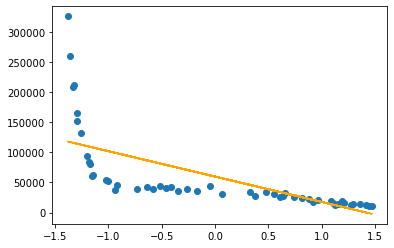

In [14]:
#Create a new column to contain the data for total_vaccinations/population
df_location.loc[:,"total_vaccinations/population"] = df_location['total_vaccinations'].div(df_location['population'])

#Set features and target
features=['total_vaccinations/population']
target=['new_cases']
df_features,df_target=get_features_targets(df_location,features,target)
#myplot = sns.scatterplot(x="total_vaccinations/population", y="new_cases", data=df_location)

#Split data into two groups for training and testing
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features,df_target,random_state=100,test_size=0.3)

#Normalize both train and test features
df_features_train = normalize_z(df_features_train)
df_features_test = normalize_z(df_features_test)

X=prepare_feature(df_features_train)
target=prepare_target(df_target_train)

iterations=1500
alpha=0.01
beta=np.zeros((2,1))

beta,J_storage=gradient_descent(X,target,beta,alpha,iterations)
pred=predict(df_features_test,beta)
print("Beta0 and beta1 is equal to: ")
print(beta)
plt.scatter(df_features_test, df_target_test)
plt.plot(df_features_test, pred, color="orange")

the_target = prepare_target(df_target_test)
r2= r2_score(the_target, pred)
print("R2 Coefficient of Determination:")
print(r2)
mse = mean_squared_error(the_target, pred)
print("Mean Squared Error:")
print(mse)

# R2 Coefficient of Determination

In [15]:
the_target = prepare_target(df_target_test)
r2= r2_score(the_target, pred)
print(r2)
mse = mean_squared_error(the_target, pred)
print(mse)


0.47027739501595534
2357072263.0297494


# Improvement
#### Using lnY instead of Y, and limited data range for (x>0.8)


Mean:
total_vaccinations/population    0.404356
dtype: float64
Std:
total_vaccinations/population    0.205019
dtype: float64
Beta0 and beta1 is equal to: 
[[10.54177744]
 [-0.78281369]]
R2 Coefficient of Determination:
0.8246703587807211
Mean Squared Error:
0.12772971386438003
Predicted result: 3224


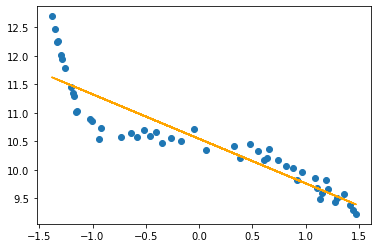

In [16]:
df_location.loc[:,"total_vaccinations/population"] = df_location['total_vaccinations'].div(df_location['population'])
features=['total_vaccinations/population']
target=['new_cases']
df_features,df_target=get_features_targets(df_location,features,target)
# Try to set the range for x


if location =='Japan':
    df_features_improved = df_features.loc[df_features["total_vaccinations/population"]>0.8]
    #print(df_location.loc[df_location["total_vaccinations"]/df_location["population"]>0.8])
else:
    df_features_improved = df_features
df_target_improved = df_target.loc[set(df_features_improved.index),:]
#print(df_features_improved)
#myplot = sns.scatterplot(x="total_vaccinations/population", y="new_cases", data=df_location)
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_improved,df_target_improved,random_state=100,test_size=0.3)

#Apply logarithm to change y to lny
df_target_train = logarithm(df_target_train, "new_cases")
df_target_test = logarithm(df_target_test, "new_cases")
#print(df_target_train)
print("Mean:")
print(df_features_train.mean())
print("Std:")
print(df_features_train.std())
#Normalize both train and test features
df_features_train = normalize_z(df_features_train)
df_features_test = normalize_z(df_features_test)


X=prepare_feature(df_features_test)
Y=prepare_target(df_target_test)
#print(df_target_test)
iterations=1500
alpha=0.01
beta=np.zeros((2,1))

beta,J_storage=gradient_descent(X,Y,beta,alpha,iterations)
pred=predict(df_features_test,beta)
print("Beta0 and beta1 is equal to: ")
print(beta)


plt.scatter(df_features_test, df_target_test)
plt.plot(df_features_test, pred, color="orange")
the_target = prepare_target(df_target_test)
r2= r2_score(the_target, pred)

print("R2 Coefficient of Determination:")
print(r2)
mse = mean_squared_error(the_target, pred)
print("Mean Squared Error:")
print(mse)

print("Predicted result: "+str(predict_num_new_cases(147586692,126050796,"Japan")))

